In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [83]:
train_data = pd.read_excel("Train.xlsx")
test_data = pd.read_excel("Test.xlsx")
data = pd.concat([train_data, test_data], axis=0) #Fusion of given datasets.
print(data.columns) #Obtaining functioning names for parameter set



Index(['timestamp', 'Temperature', 'Precipitation', 'Snowfall',
       'Totalcloudiness', 'Highcloudcover', 'Mediumcloudcover',
       'Lowcloudcover', 'Pressure', 'WindSpeed', 'WindDirection', 'WindGusts'],
      dtype='object')


In [84]:
#Parameter sets declaration
input_parameters = ["timestamp"]
output_parameters = [
    "Temperature",
    "Precipitation",
    "Snowfall",
    "Totalcloudiness",
    "Lowcloudcover",
    "Mediumcloudcover",
    "Highcloudcover",
    "Pressure",
    "WindSpeed",
    "WindDirection",
    "WindGusts",
]

In [85]:
data["timestamp"] = pd.to_datetime(data["timestamp"], format="%d.%m.%Y %H:%M:%S")
data.set_index("timestamp", inplace=True)
data.sort_index(inplace=True)

In [86]:
data.fillna(method="ffill", inplace=True)

In [87]:
test_dates = test_data["timestamp"]

In [88]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [89]:
window_size = 24
X = []
y = []
for i in range(len(data) - window_size):
    X.append(scaled_data[i:i + window_size])
    y.append(scaled_data[i + window_size])
X = np.array(X)
y = np.array(y)

In [90]:
#dataset split
train_size = len(train_data)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [91]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

In [92]:
model = LinearRegression()
model.fit(X_train_flattened, y_train)

LinearRegression()

Raw prediction on entire dataframe displayed inside the output cell below.
Input sample is a major segment taken from testing dataset (2023-06-02 to 2024-06-30).

In [93]:
predictions = model.predict(X_test_flattened)
predictions = scaler.inverse_transform(predictions)
output_df = pd.DataFrame(predictions, columns=output_parameters)
output_df["timestamp"] = test_dates.values[-len(output_df):]
output_df.set_index("timestamp", inplace=True)
print(output_df)

                     Temperature  Precipitation  Snowfall  Totalcloudiness  \
timestamp                                                                    
2023-06-02 00:00:00    20.103418       0.101871  0.006291        78.630703   
2023-06-02 01:00:00    19.547866       0.010285  0.002714        47.322703   
2023-06-02 02:00:00    18.592685       0.014465  0.003514        53.632705   
2023-06-02 03:00:00    15.635357       0.023526  0.000807        53.532103   
2023-06-02 04:00:00    13.033133       0.034255  0.003200        38.375644   
...                          ...            ...       ...              ...   
2023-06-30 19:00:00    22.698722       0.013032 -0.004872        45.875363   
2023-06-30 20:00:00    22.345861       0.074179 -0.002540        67.197266   
2023-06-30 21:00:00    21.693822      -0.037357 -0.000426        33.281553   
2023-06-30 22:00:00    20.977570       0.087561 -0.005133        24.316740   
2023-06-30 23:00:00    18.983391       0.076921 -0.002004       

Basic stat. estimators' calculations shown below.
Values are not perfect, however they represent comparatively high level of efficiency. (other models were tested)


In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, model.predict(X_test_flattened))
mse = mean_squared_error(y_test, model.predict(X_test_flattened))
r2 = r2_score(y_test, model.predict(X_test_flattened))

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared (R2) Score:", r2)

Mean Absolute Error: 0.2054830926679661
Mean Squared Error: 0.17058217313677126
R-squared (R2) Score: -1.9156159045734946e+28


Function below gives opportunity to observe how precise model is. The plot gives information on selected day from dataset to compare predicted parameter value and its actual magnitude.

Use parameter names from following set: [
"Temperature",
"Precipitation",
"Snowfall",
"Totalcloudiness",
"Lowcloudcover",
"Mediumcloudcover",
"Highcloudcover",
"Pressure",
"WindSpeed",
"WindDirection",
"WindGusts",
]

Don't forget to select day in between borders of 2023-06-02 and 2023-06-30


In [95]:
def plot_prediction_graph(day_to_plot, unknown_parameter):
    predicted_parameter = output_df.loc[day_to_plot, unknown_parameter]
    actual_parameter = test_data.loc[test_data["timestamp"].dt.date == pd.to_datetime(day_to_plot).date(), unknown_parameter]
    hours = np.arange(0, len(predicted_parameter))
    plt.plot(hours, predicted_parameter,label=f"Predicted {unknown_parameter}")
    plt.plot(hours, actual_parameter, label=unknown_parameter)
    plt.xlabel("Hour")
    plt.ylabel(unknown_parameter)
    plt.title(f"Predicted and Actual {unknown_parameter} on {day_to_plot}")
    plt.legend()
    plt.grid(True)
    plt.xticks(hours, rotation=45)
    plt.show()


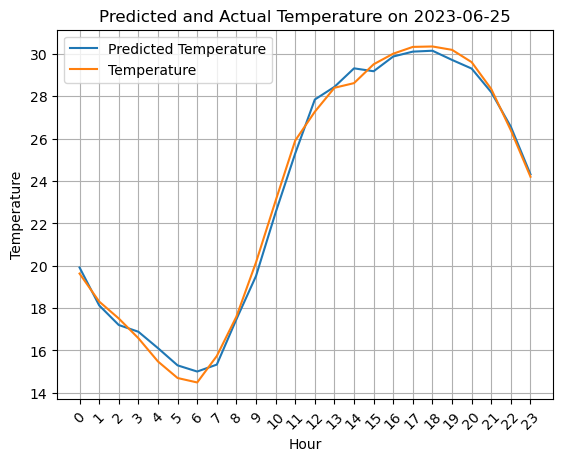

In [96]:
day_to_plot = "2023-06-25"
unknown_parameter = "Temperature"

plot_prediction_graph(day_to_plot, unknown_parameter)

Work done before is a good foundation on weather forecasting. We can use obtained pattern recognition to draw forecats for future N number of days. Set number of desired days to get weather forecast. Notice, forecasts are precise only in scope of model's efficiency. Hence, the efficiency of model will decrease in correlation with prediction range. It means that with un-updated data temperature values will drop unnaturally.

In [173]:
# Change N to desired value
N = 1

In [174]:
future_dates = pd.date_range(test_dates.iloc[-1] + pd.Timedelta(hours=1), periods=24 * N, freq='H')

In [175]:
future_data = scaled_data[-window_size:]
for i in range(N * 24 - window_size):
    next_data = model.predict(future_data[-window_size:].reshape(1, -1))
    future_data = np.vstack((future_data, next_data))
future_predictions = scaler.inverse_transform(future_data)
future_output_df = pd.DataFrame(future_predictions, columns=output_parameters)
future_output_df["timestamp"] = future_dates
future_output_df.set_index("timestamp", inplace=True)

In [176]:
print(future_output_df)

                     Temperature  Precipitation  Snowfall  Totalcloudiness  \
timestamp                                                                    
2023-07-01 00:00:00    21.890530            0.5       0.0       100.000000   
2023-07-01 01:00:00    19.730530            0.4       0.0       100.000000   
2023-07-01 02:00:00    18.880530            0.6       0.0       100.000000   
2023-07-01 03:00:00    18.180529            0.8       0.0        43.000000   
2023-07-01 04:00:00    17.660528            0.2       0.0         9.600000   
2023-07-01 05:00:00    17.500528            0.1       0.0        30.000002   
2023-07-01 06:00:00    17.620530            0.0       0.0       100.000000   
2023-07-01 07:00:00    18.240528            0.2       0.0       100.000000   
2023-07-01 08:00:00    17.940529            0.9       0.0       100.000000   
2023-07-01 09:00:00    18.580528            0.3       0.0       100.000000   
2023-07-01 10:00:00    18.580528            0.7       0.0       